# Different Optimizer - Adam (l_r = 0.001, beta1 = 0.5) & Gradient Descent (Initial l_r = 0.1, exponential decay)

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np

### Data loading

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


### Hyperparameters

In [3]:
ops = ['Adam', 'GD']
l_r = 0.1 # initial learning rate
global_step = tf.Variable(0, trainable=False)
l_r = tf.train.exponential_decay(learning_rate=l_r,
                                 global_step=global_step,
                                 decay_steps = 3000, 
                                 decay_rate = 0.98)
epoch = 2000
batch_size = 128

In [4]:
n_inputs = 28 # MNIST data input, img shape = (28, 28), view the graph row by row
n_steps = 28 # Time steps - shift 28 times
n_hidden_units = 128 # Neuron no. in hidden layer
n_classes = 10 # 0~9

### Placeholder - input and output data holders

In [5]:
x = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_classes])

### Create static initial parameters

In [6]:
# create static initial parameters
w_h1 = tf.random_normal([n_inputs, n_hidden_units])
w_out = tf.random_normal([n_hidden_units, n_classes])
b_h1 = tf.random_normal([n_hidden_units, ])
b_out = tf.random_normal([n_classes, ])

In [7]:
def get_static_w_b():
    # create static initial parameters
    w_h1 = tf.random_normal([n_inputs, n_hidden_units])
    w_out = tf.random_normal([n_hidden_units, n_classes])
    b_h1 = tf.random_normal([n_hidden_units, ])
    b_out = tf.random_normal([n_classes, ])
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        w_h1, w_out, b_h1, b_out = sess.run([w_h1, w_out, b_h1, b_out])
    weights = dict()
    biases = dict()
    # Create weights and biases for diff ops
    for op in ops:
        weights[op] = {
        # (28 inputs, 128 neurons)
        'h1':tf.Variable(tf.constant(w_h1)),
        # (128 inputs, 10 neurons)
        'out':tf.Variable(tf.constant(w_out))
        }
        biases[op] = {
        # (128 neurons, )
        'h1':tf.Variable(tf.constant(b_h1)),
        # (10 neurons, )
        'out':tf.Variable(tf.constant(b_out))
        }
    return weights, biases

### RNN structure

In [8]:
def RNN(X, weights, biases, op='Adam'):
    # h1
    X = tf.reshape(X, [-1, n_inputs])
    X_in = tf.matmul(X, weights[op]['h1']) + biases[op]['h1']
    X_in = tf.reshape(X_in, [-1, n_steps, n_hidden_units])
    
    with tf.variable_scope(op):
        # rnn cell
        rnn_cell = tf.contrib.rnn.core_rnn_cell.BasicLSTMCell(n_hidden_units,
                                                              forget_bias=1.0,
                                                              state_is_tuple=True)
        _init_state = rnn_cell.zero_state(batch_size, dtype=tf.float32)
        # outputs: the rnns outputs
        outputs, states = tf.nn.dynamic_rnn(cell=rnn_cell,
                                            inputs=X_in,
                                            initial_state=_init_state,
                                            time_major=False)
    
    # output layer
    outputs = tf.unstack(tf.transpose(outputs, [1, 0, 2]))
    results = tf.matmul(outputs[-1], weights[op]['out']) + biases[op]['out']
    
    return results

In [9]:
def get_pred(x, weights, biases):
    pred = dict()
    for op in ops:
        pred[op] = RNN(x, weights, biases, op=op)
    return pred

def get_loss(pred, y):
    loss = dict()
    for op in ops:
        loss[op] = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred[op], labels=y))
    return loss

def get_accu(pred, y):
    accu = dict()
    for op in ops:
        accu[op] = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(pred[op], 1), tf.argmax(y, 1)), tf.float32))
    return accu

def get_op(loss, l_r):
    train_op = dict()
    train_op['Adam'] = tf.train.AdamOptimizer(0.001, beta1=0.5).minimize(loss['Adam'])
    train_op['GD'] = tf.train.GradientDescentOptimizer(l_r).minimize(loss['GD'])
    return train_op

In [10]:
ex_time = 0

### Experiments

In [11]:
import time
loss_val_train = dict()
loss_val_test = dict()
accu_val_train = dict()
accu_val_test = dict()
time_span = dict()
for op in ops:
    loss_val_train[op] = list()
    loss_val_test[op] = list()
    accu_val_train[op] = list()
    accu_val_test[op] = list()
    time_span[op] = list()
for ex in range(10):
    ex_time += 1
    with tf.variable_scope('ex'+str(ex_time)):
        weights, biases = get_static_w_b()
        pred = get_pred(x, weights, biases)
        loss = get_loss(pred, y)
        accu = get_accu(pred, y)
        train_op = get_op(loss, l_r)
    init2 = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init2)
        startTime = time.time()
        for epo in range(epoch):
            # read training data
            batch_xs_train, batch_ys_train = mnist.train.next_batch(batch_size)
            batch_xs_train = batch_xs_train.reshape([batch_size, n_steps, n_inputs])
            # read testing data
            batch_xs_test, batch_ys_test = mnist.test.next_batch(batch_size)
            batch_xs_test = batch_xs_test.reshape([batch_size, n_steps, n_inputs])
            # Training
            for op in ops:
                t1 = time.time()
                sess.run([train_op[op]], feed_dict={
                    x:batch_xs_train,
                    y:batch_ys_train
                })
                t2 = time.time()
                # save time-span
                time_span[op].append(t2-t1)
                # find loss and accuracy for training set
                l, a = sess.run([loss[op], accu[op]], feed_dict={
                    x:batch_xs_train,
                    y:batch_ys_train
                })
                loss_val_train[op].append(l)
                accu_val_train[op].append(a)
                # find loss and accuracy for testing set
                l, a = sess.run([loss[op], accu[op]], feed_dict={
                    x:batch_xs_test,
                    y:batch_ys_test
                })
                loss_val_test[op].append(l)
                accu_val_test[op].append(a)
            
            # print result each 100 epochs
            if (epo+1)%100 == 0:
                print('Epoch', epo+1,
                      ', Losses:', '%2.4f, %2.4f'\
                      % (loss_val_train['Adam'][-1], loss_val_train['GD'][-1]),
                      ', Accuracies:', '%2.4f, %2.4f'\
                      % (accu_val_train['Adam'][-1], accu_val_train['GD'][-1]))
        endTime = time.time()
        timespan = endTime - startTime
        print('--------------------EX'+str(ex+1), 'done.', 'Spent', '%2.2f' % timespan, 'secs.')
        #writer = tf.summary.FileWriter("logs/", sess.graph)
# tensorboard: terminal >> tensorboard --logdir='logs/'

#save the result
np.save('./diffOP_data/loss_val_train_diffOP_exp', loss_val_train)
np.save('./diffOP_data/loss_val_test_diffOP_exp', loss_val_test)
np.save('./diffOP_data/accu_val_train_diffOP_exp', accu_val_train)
np.save('./diffOP_data/accu_val_test_diffOP_exp', accu_val_test)
np.save('./diffOP_data/time_span_diffOP_exp', time_span)

Epoch 100 , Losses: 0.5295, 1.7582 , Accuracies: 0.7812, 0.4062
Epoch 200 , Losses: 0.2554, 1.1479 , Accuracies: 0.9297, 0.6016
Epoch 300 , Losses: 0.0877, 0.7738 , Accuracies: 0.9688, 0.7734
Epoch 400 , Losses: 0.1240, 0.6044 , Accuracies: 0.9531, 0.8203
Epoch 500 , Losses: 0.0512, 0.6114 , Accuracies: 0.9922, 0.8125
Epoch 600 , Losses: 0.1207, 0.5832 , Accuracies: 0.9766, 0.7812
Epoch 700 , Losses: 0.0624, 0.5442 , Accuracies: 0.9844, 0.7734
Epoch 800 , Losses: 0.0201, 0.4053 , Accuracies: 1.0000, 0.8438
Epoch 900 , Losses: 0.0370, 0.3817 , Accuracies: 0.9922, 0.8984
Epoch 1000 , Losses: 0.0215, 0.3442 , Accuracies: 1.0000, 0.8906
Epoch 1100 , Losses: 0.0077, 0.2779 , Accuracies: 1.0000, 0.8906
Epoch 1200 , Losses: 0.0120, 0.2259 , Accuracies: 1.0000, 0.9453
Epoch 1300 , Losses: 0.0146, 0.3925 , Accuracies: 1.0000, 0.8594
Epoch 1400 , Losses: 0.0233, 0.4561 , Accuracies: 1.0000, 0.8828
Epoch 1500 , Losses: 0.0254, 0.4262 , Accuracies: 1.0000, 0.8906
Epoch 1600 , Losses: 0.0054, 0.250

Epoch 400 , Losses: 0.1270, 0.8425 , Accuracies: 0.9531, 0.7500
Epoch 500 , Losses: 0.0626, 0.5344 , Accuracies: 0.9922, 0.8516
Epoch 600 , Losses: 0.1073, 0.7093 , Accuracies: 0.9766, 0.7734
Epoch 700 , Losses: 0.1036, 0.6753 , Accuracies: 0.9688, 0.7500
Epoch 800 , Losses: 0.0854, 0.4910 , Accuracies: 0.9688, 0.8516
Epoch 900 , Losses: 0.0486, 0.4217 , Accuracies: 0.9922, 0.8672
Epoch 1000 , Losses: 0.0734, 0.5048 , Accuracies: 0.9766, 0.8672
Epoch 1100 , Losses: 0.0509, 0.3810 , Accuracies: 0.9922, 0.8828
Epoch 1200 , Losses: 0.0221, 0.3987 , Accuracies: 1.0000, 0.8750
Epoch 1300 , Losses: 0.0123, 0.3125 , Accuracies: 1.0000, 0.9062
Epoch 1400 , Losses: 0.0187, 0.2496 , Accuracies: 1.0000, 0.9375
Epoch 1500 , Losses: 0.0248, 0.3178 , Accuracies: 0.9922, 0.9062
Epoch 1600 , Losses: 0.0390, 0.5012 , Accuracies: 0.9922, 0.8125
Epoch 1700 , Losses: 0.0182, 0.3329 , Accuracies: 1.0000, 0.8750
Epoch 1800 , Losses: 0.0128, 0.5598 , Accuracies: 1.0000, 0.8047
Epoch 1900 , Losses: 0.0416, 0.

## Result

In [12]:
epoch = 2000
ops = ['Adam', 'GD']
import numpy as np
loss_val_train = np.load('./diffOP_data/loss_val_train_diffOP_exp.npy')
loss_val_test = np.load('./diffOP_data/loss_val_test_diffOP_exp.npy')
accu_val_train = np.load('./diffOP_data/accu_val_train_diffOP_exp.npy')
accu_val_test = np.load('./diffOP_data/accu_val_test_diffOP_exp.npy')
time_span = np.load('./diffOP_data/time_span_diffOP_exp.npy')

loss_val_train = loss_val_train[None][0]
loss_val_test = loss_val_test[None][0]
accu_val_train = accu_val_train[None][0]
accu_val_test = accu_val_test[None][0]
time_span = time_span[None][0]

In [13]:
# result ploting
import matplotlib.pyplot as plt

### Epoch - Training loss & accuracy

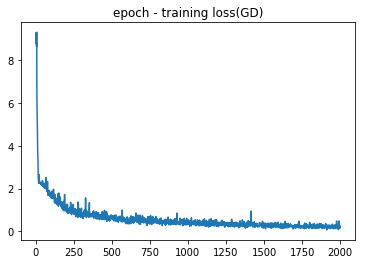

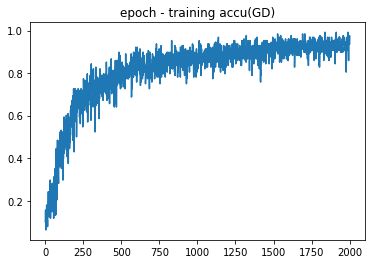

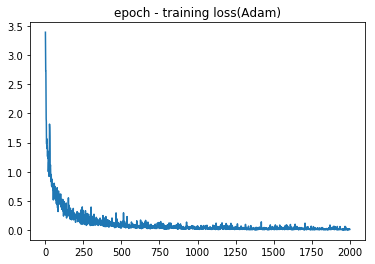

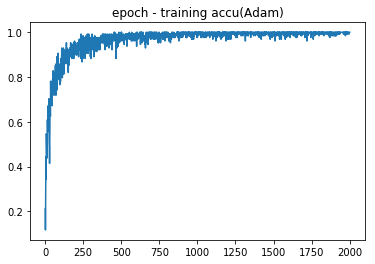

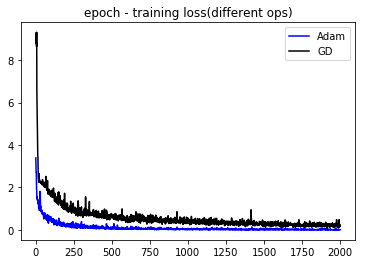

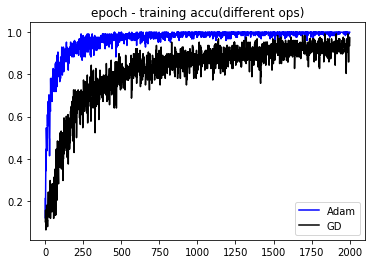

In [14]:
# epoch v.s.training loss
i = 0
for op, losses in loss_val_train.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - training loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(accu_val_train[op][-epoch:])+1), accu_val_train[op][-epoch:])
    plt.title('epoch - training accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(1, len(loss_val_train['Adam'][-epoch:])+1), loss_val_train['Adam'][-epoch:], 'b',
         range(1, len(loss_val_train['GD'][-epoch:])+1), loss_val_train['GD'][-epoch:], 'k')
plt.title('epoch - training loss(different ops)')
plt.legend(['Adam', 'GD'], loc=1)
plt.show()

plt.plot(range(1, len(accu_val_train['Adam'][-epoch:])+1), accu_val_train['Adam'][-epoch:], 'b',
         range(1, len(accu_val_train['GD'][-epoch:])+1), accu_val_train['GD'][-epoch:], 'k')
plt.title('epoch - training accu(different ops)')
plt.legend(['Adam', 'GD'], loc=4)

plt.show()

### Epoch - Testing loss & accuracy

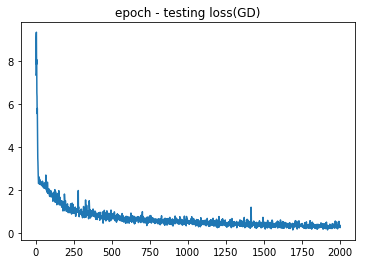

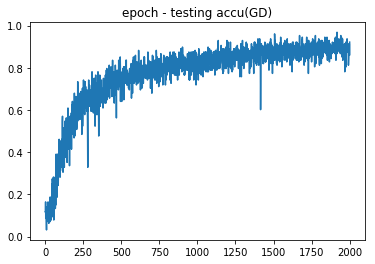

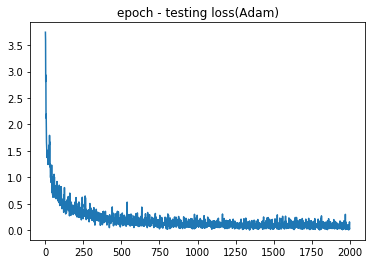

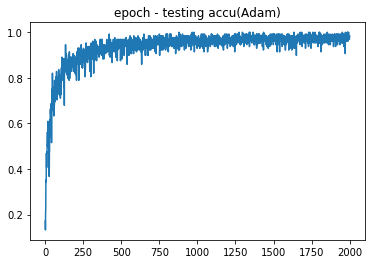

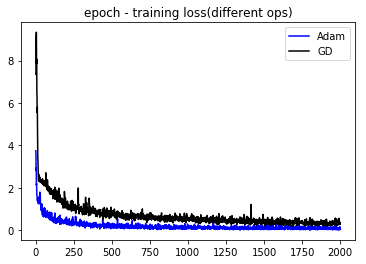

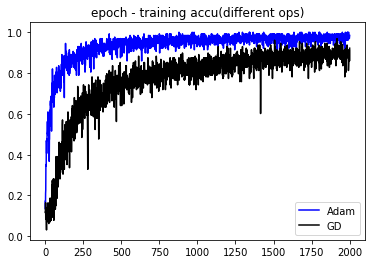

In [15]:
# epoch v.s. testing loss
i = 0
for op, losses in loss_val_test.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(losses[-epoch:])+1), losses[-epoch:])
    plt.title('epoch - testing loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(1, len(accu_val_test[op][-epoch:])+1), accu_val_test[op][-epoch:])
    plt.title('epoch - testing accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(1, len(loss_val_test['Adam'][-epoch:])+1), loss_val_test['Adam'][-epoch:], 'b',
         range(1, len(loss_val_test['GD'][-epoch:])+1), loss_val_test['GD'][-epoch:], 'k')
plt.title('epoch - training loss(different ops)')
plt.legend(['Adam', 'GD'], loc=1)
plt.show()

plt.plot(range(1, len(accu_val_test['Adam'][-epoch:])+1), accu_val_test['Adam'][-epoch:], 'b',
         range(1, len(accu_val_test['GD'][-epoch:])+1), accu_val_test['GD'][-epoch:], 'k')
plt.title('epoch - training accu(different ops)')
plt.legend(['Adam', 'GD'], loc=4)

plt.show()

In [16]:
# smooth the line
len(loss_val_train['Adam']) # 782
last_point = 0
loss_val_train_ = dict()
loss_val_test_ = dict()
accu_val_train_ = dict()
accu_val_test_ = dict()
for op in ops:
    # training loss
    loss_val_train_[op] = list()
    loss_list = loss_val_train[op][-epoch:]
    for i in range(int(len(loss_list)/10)):
        loss_val_train_[op].append(np.mean(loss_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(loss_list)%10 != 0:
        loss_val_train_[op].append(np.mean(loss_list[last_point:]))
    # testing loss
    loss_val_test_[op] = list()
    loss_list = loss_val_test[op][-epoch:]
    for i in range(int(len(loss_list)/10)):
        loss_val_test_[op].append(np.mean(loss_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(loss_list)%10 != 0:
        loss_val_test_[op].append(np.mean(loss_list[last_point:]))
    # training accu
    accu_val_train_[op] = list()
    accu_list = accu_val_train[op][-epoch:]
    for i in range(int(len(accu_list)/10)):
        accu_val_train_[op].append(np.mean(accu_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(accu_list)%10 != 0:
        accu_val_train_[op].append(np.mean(accu_list[last_point:]))
    # testing accu
    accu_val_test_[op] = list()
    accu_list = accu_val_test[op][-epoch:]
    for i in range(int(len(accu_list)/10)):
        accu_val_test_[op].append(np.mean(accu_list[i*10:i*10+10]))
        last_point = i*10+10
    if len(accu_list)%10 != 0:
        accu_val_test_[op].append(np.mean(accu_list[last_point:]))

### Epoch - Training loss & accuracy (smooth)

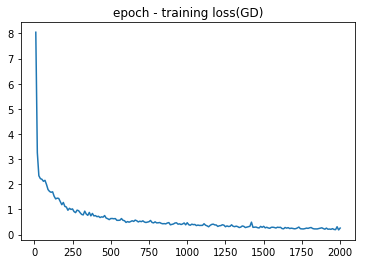

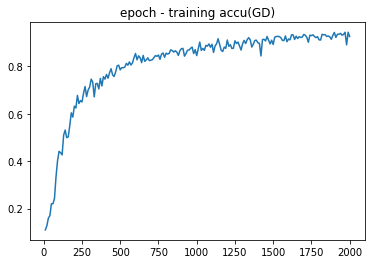

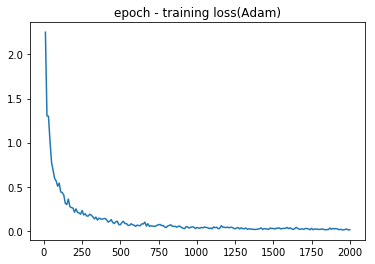

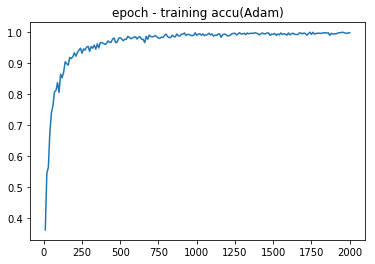

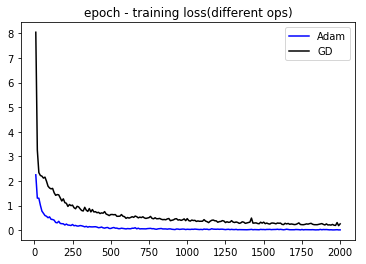

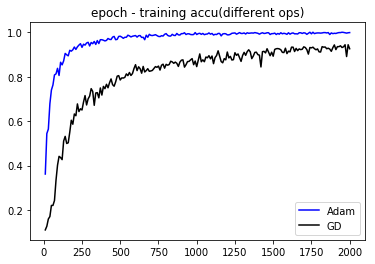

In [17]:
# epoch v.s.training loss & accu - smooth
i = 0
for op, losses in loss_val_train_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(losses[-epoch:])*10+10, 10), losses[-epoch:])
    plt.title('epoch - training loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(accu_val_train_[op][-epoch:])*10+10, 10), accu_val_train_[op][-epoch:])
    plt.title('epoch - training accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(10, len(loss_val_train_['Adam'][-epoch:])*10+10, 10), loss_val_train_['Adam'][-epoch:], 'b',
         range(10, len(loss_val_train_['GD'][-epoch:])*10+10, 10), loss_val_train_['GD'][-epoch:], 'k')
plt.title('epoch - training loss(different ops)')
plt.legend(['Adam', 'GD'], loc=1)
plt.savefig('./diffOP_data/epoch_loss_train_exp.png')
plt.show()

plt.plot(range(10, len(accu_val_train_['Adam'][-epoch:])*10+10, 10), accu_val_train_['Adam'][-epoch:], 'b',
         range(10, len(accu_val_train_['GD'][-epoch:])*10+10, 10), accu_val_train_['GD'][-epoch:], 'k')
plt.title('epoch - training accu(different ops)')
plt.legend(['Adam', 'GD'], loc=4)
plt.savefig('./diffOP_data/epoch_accu_train_exp.png')
plt.show()

### Epoch - Testing loss & accuracy (smooth)

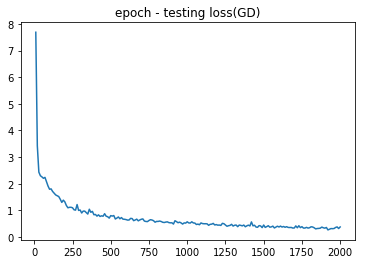

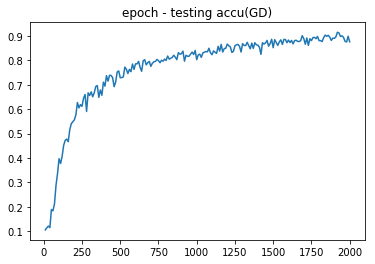

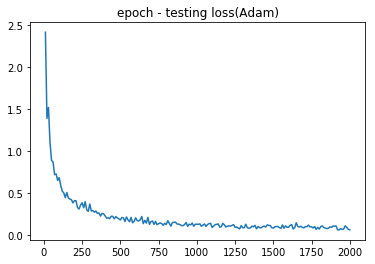

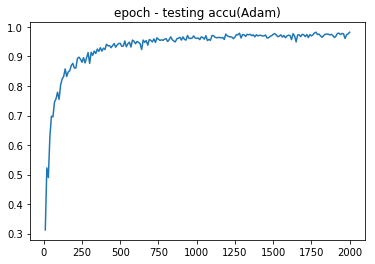

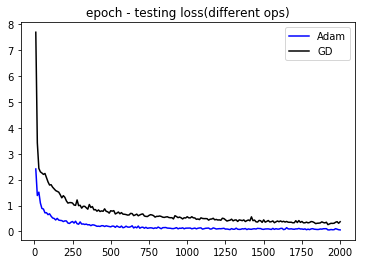

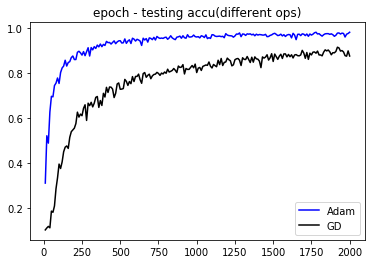

In [18]:
# epoch v.s.testing loss - smooth
i = 0
for op, losses in loss_val_test_.items():
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(losses[-epoch:])*10+10, 10), losses[-epoch:])
    plt.title('epoch - testing loss('+op+')')
    plt.show()
    i += 1
    plt.close()
    plt.figure(i)
    plt.plot(range(10, len(accu_val_test_[op][-epoch:])*10+10, 10), accu_val_test_[op][-epoch:])
    plt.title('epoch - testing accu('+op+')')  
    plt.show()
    i += 1
    
plt.plot(range(10, len(loss_val_test_['Adam'][-epoch:])*10+10, 10), loss_val_test_['Adam'][-epoch:], 'b',
         range(10, len(loss_val_test_['GD'][-epoch:])*10+10, 10), loss_val_test_['GD'][-epoch:], 'k')
plt.title('epoch - testing loss(different ops)')
plt.legend(['Adam', 'GD'], loc=1)
plt.savefig('./diffOP_data/epoch_loss_test_exp.png')
plt.show()

plt.plot(range(10, len(accu_val_test_['Adam'][-epoch:])*10+10, 10), accu_val_test_['Adam'][-epoch:], 'b',
         range(10, len(accu_val_test_['GD'][-epoch:])*10+10, 10), accu_val_test_['GD'][-epoch:], 'k')
plt.title('epoch - testing accu(different ops)')
plt.legend(['Adam', 'GD'], loc=4)
plt.savefig('./diffOP_data/epoch_accu_test_exp.png')
plt.show()

# Statistics Inference : ANOVA and T-test

In [19]:
from scipy import stats as st
# ANOVA:  f_val, p_val = st.f_oneway(data_array1, data_array2, ...)

In [20]:
# data extract
loss_means_train = dict()
for op, losses in loss_val_train.items():
    mean = list()
    ex_time = len(losses)/epoch
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_train[op] = mean

loss_means_test = dict()
for op, losses in loss_val_test.items():
    mean = list()
    ex_time = len(losses)/epoch
    
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(losses[(ex+1)*epoch-100:(ex+1)*epoch]))
    loss_means_test[op] = mean

accu_means_train = dict()
for op, accus in accu_val_train.items():
    mean = list()
    ex_time = len(accus)/epoch
    
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(accus[(ex+1)*epoch-100:(ex+1)*epoch]))
    accu_means_train[op] = mean
    
accu_means_test = dict()
for op, accus in accu_val_test.items():
    mean = list()
    ex_time = len(accus)/epoch
    
    print(op, ex_time)
    for ex in range(int(ex_time)):
        mean.append(np.mean(accus[(ex+1)*epoch-100:(ex+1)*epoch]))
    accu_means_test[op] = mean

GD 10.0
Adam 10.0
GD 10.0
Adam 10.0
GD 10.0
Adam 10.0
GD 10.0
Adam 10.0


In [21]:
np.save('./diffOP_data/loss_means_train_diffOP_exp', loss_means_train)
np.save('./diffOP_data/loss_means_test_diffOP_exp', loss_means_test)
np.save('./diffOP_data/accu_means_train_diffOP_exp', accu_means_train)
np.save('./diffOP_data/accu_means_test_diffOP_exp', accu_means_test)
loss_means_train, loss_means_test, accu_means_train, accu_means_test

({'Adam': [0.018500244,
   0.015501035,
   0.020185387,
   0.016663179,
   0.014277532,
   0.017039817,
   0.018470379,
   0.015580365,
   0.017854962,
   0.016292507],
  'GD': [0.25785312,
   0.22778422,
   0.17940943,
   0.31955934,
   0.20997567,
   0.21971264,
   0.2757479,
   0.30563465,
   0.20981231,
   0.22714147]},
 {'Adam': [0.079171032,
   0.080935672,
   0.081593752,
   0.084593952,
   0.090965211,
   0.089259513,
   0.083997123,
   0.086758316,
   0.081537485,
   0.075896047],
  'GD': [0.36580336,
   0.33292729,
   0.28736696,
   0.42266551,
   0.30892408,
   0.31821957,
   0.37931406,
   0.41581494,
   0.29285359,
   0.32710057]},
 {'Adam': [0.99734378,
   0.99757814,
   0.99640626,
   0.99687499,
   0.99796873,
   0.99757814,
   0.99664062,
   0.99757814,
   0.9971875,
   0.99773437],
  'GD': [0.92374998,
   0.9346875,
   0.94757813,
   0.9002344,
   0.94093752,
   0.93609375,
   0.91664064,
   0.90820312,
   0.93953127,
   0.93007815]},
 {'Adam': [0.97609377,
   0.97546

### training loss

In [22]:
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(loss_means_train[op])
    StD[op] = np.std(loss_means_train[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))

         OP      mean     StD    
        Adam    0.0170   0.0017
          GD    0.2433   0.0428


### training accuracy

In [23]:
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(accu_means_train[op])
    StD[op] = np.std(accu_means_train[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))

         OP      mean     StD    
          GD    0.9278   0.0145
        Adam    0.9973   0.0005


### testing loss

In [24]:
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(loss_means_test[op])
    StD[op] = np.std(loss_means_test[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))

         OP      mean     StD    
        Adam    0.0835   0.0044
          GD    0.3451   0.0460


### testing accuracy

In [25]:
# sort them by means
mean = dict()
StD = dict()
for op in ops:
    mean[op] = np.mean(accu_means_test[op])
    StD[op] = np.std(accu_means_test[op])
mus_sort = sorted(mean.values())
ops_sort = sorted(mean, key=mean.__getitem__)
print('         OP      mean     StD    ')
for i in range(len(ops_sort)):
    print('%12s    %2.4f   %2.4f' % (ops_sort[i], mus_sort[i], StD[ops_sort[i]]))

         OP      mean     StD    
          GD    0.8895   0.0148
        Adam    0.9742   0.0011
